# **MÓDULO 27 - Projeto de Doenças Cardiovasculares - Regressão Logística**


Nessa tarefa iremos construir um modelo que nos ajude a prever doenças cardiovasculares, a base contém dados reais.

age - idade dos pacientes

gender - genero (2 mulheres) (1 homens)

height - altura dos pacientes

weight - peso dos pacientes

gluc - glicose

smoke - fumante (1) não fumante (0)

alco - consume alcool (1) não consome (0)

active - realiza atividades fisicas (1) não realiza (0)

cardio_disease - tem doença cardio (1) não tem (0) - Variável target


Seu objetivo é utilizar esses dados históricos dos pacientes e construir um bom modelo de regressão capaz de indicar se novos pacientes estão propensos a doenças cariovasculares ou não.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# 1) Comece carregando e tratando a base de dados.
Assim como na aula essa nova base não passou por pré processamento nenhum então nessa etapa, carrega os dados, verifique os tipos de dados, verifique se temos dados faltantes e outliers.
Quando necessário realize o tratamento.


In [2]:
# Lendo o csv

df = pd.read_csv("CARDIO_BASE.csv", delimiter=';', decimal=',')

df.head(10)

,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio_disease
0,50,2,168,62.0,1,1,0,0,1,0
1,55,1,156,85.0,3,1,0,0,1,1
2,52,1,165,64.0,3,1,0,0,0,1
3,48,2,169,82.0,1,1,0,0,1,1
4,48,1,156,56.0,1,1,0,0,0,0
5,60,1,151,67.0,2,2,0,0,0,0
6,61,1,157,93.0,3,1,0,0,1,0
7,62,2,178,95.0,3,3,0,0,1,1
8,48,1,158,71.0,1,1,0,0,1,0
9,54,1,164,68.0,1,1,0,0,0,0


In [3]:
# Verificando as informações do df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             10000 non-null  int64  
 1   gender          10000 non-null  int64  
 2   height          10000 non-null  int64  
 3   weight          10000 non-null  float64
 4   cholesterol     10000 non-null  int64  
 5   gluc            10000 non-null  int64  
 6   smoke           10000 non-null  int64  
 7   alco            10000 non-null  int64  
 8   active          10000 non-null  int64  
 9   cardio_disease  10000 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 781.4 KB


Observações iniciais:

- Não há valores nulos
- Os dados se encontram nos tipos corretos.

In [4]:
# Verificando a presença de Outliers

df.describe()

,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio_disease
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,53.288300,1.345400,164.308200,74.303710,1.365000,1.222200,0.089000,0.053700,0.797200,0.503100
std,6.796234,0.475522,8.178796,14.566353,0.677658,0.565561,0.284758,0.225436,0.402105,0.500015
min,30.000000,1.000000,70.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,58.000000,2.000000,170.000000,82.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,200.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Observações:

- Duas variáveis se demonstraram propícias a possuirem Outliers, sendo elas: height e weight. Logo se faz necessário uma análise mais profunda.

In [5]:
# Tratando coluna "height"

px.box(
    df,
    "height",
    hover_data="age"
)

Observação:

Com o boxplot foi possível ver que há sim outliers e que com valores bem gritantes. No gráfico também foi utilizado idade para verificar se alguns casos foossem na verdade, criaças (Nos caso da pessoas que possuem alturas menores), porém não foi o caso, seria justo pensar na existência de pessoas com nanismo mas ainda nesse caso há um limite. Logo, por haver uma pequena quantidade de outliers, irei retirar todos que tiverem menos de 130 cm e mais que 200 cm visando, respeitar algumas condições físicas e ao mesmo tempo, não atrapalhar o aprendizado do modelo, já que nessa situação, as condições estabelecidas apontam sim um outlier, que pode por exemplo ter sido causado por erro de digitação.

In [6]:
# Removendo outliers de height

cond = (df["height"] > 200) | (df["height"] < 130)
df = df[~cond]

# Fazendo a verificação para ver se os outliers foram removidos

px.box(
    df,
    "height",
    hover_data="age"
)

Observação:
- A remoção dos outliers foi feita, ainda há valores nos quadrantes superiores e inferiores mas são valores que mais possíveis e que não indica necessariamente um outlier.

In [7]:
# Tratando coluna "weight"

px.box(
    df,
    "weight",
    hover_data= {
        "cardio_disease",
        "active",
        "age",
        "height"
    } 
)

Observação:
- É sim possível ver que há sim forte índicios de outliers, mas muitos que fojem dos quandrantes são possíveis, logo decidi retirar todos que possuem pesos acimas 160, pois com os dados auxiliares foi pessível ver algumas incoerências que provavelmente indicam outliers, tirarei quem tem menos de 39 kg pois apesar de não ser com certeza um outlier, é possível que seja, e por ser apenas 1 caso, o efeito de retira-lo provavelmente será mais benéfico para o modelo do que mante-lo.
- Realizarei a remoção dos dados previstos como outliers, pois a quantidade de dados é bem pequena, logo, faz mais sentidos remove-los, visto que por ser uma quantidade pequena, não terá muito impacto.

In [8]:
# Retirando outliers "weight"

cond = (df["weight"] > 160) | (df["weight"] < 39)
df = df[~cond]

# Realizando verificação

px.box(
    df,
    "weight"
)

Observação:
- A remoção foi concluida, e novamente, ainda há dados que saem dos quadrantes, mas eles são possíveis, e não indicam outliers necessariamente.

In [9]:
# Verificando como está a distribuição agora

df.describe()


,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio_disease
count,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000,9977.000000
mean,53.297184,1.344993,164.371555,74.221620,1.365441,1.222612,0.089005,0.053824,0.797033,0.503358
std,6.790969,0.475390,7.853087,14.262062,0.677985,0.566063,0.284765,0.225681,0.402228,0.500014
min,30.000000,1.000000,130.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,58.000000,2.000000,170.000000,82.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,198.000000,159.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Observação:
- A distribuição está bem melhor, e agora não há indicações de outliers (Vale ressaltar também que só houve uma perda de 23 linhas, em um df de 10000, não é  praticamente nada prejudicial)

# 2) Agora é hora de explorar os dados com uma análise bem completa.
Plote pelo menos 3 gráficos analisando o comportamento da variável cardio com outras variaveis da sua preferência (análise bivariada). Não se esqueça de trazer insights acerca do analisado.


Os gráficos serão:

- Gender x Cardio_disease

- Cholestrol x Cardio_disease

- Age x Cardio_disease

Extra:

- Gender x Active 

- Cholestrol x Active

# Gender x Cardio_disease
(Gênero x doença Cardíaca)

Motivo: Escolhi esse para descobrir se existe algum tipo de associação entre Gênero e doenças cardíacas. Caso tenha, será mais fácil futuramente descobrir qual é o grupo de maior risco.

Insights: Com o gráfico foi possível ver que há um desbalanceamento alto, ou seja, há muito mais homens do que mulheres, todavia em relação a quem desenvolveu alguma doença cadíaca, a diferença entre homens e mulheres não é tão grande... Mostrando, com base no gráfico, que não há um sexo mais propício a desenvolver esse tipo de doença

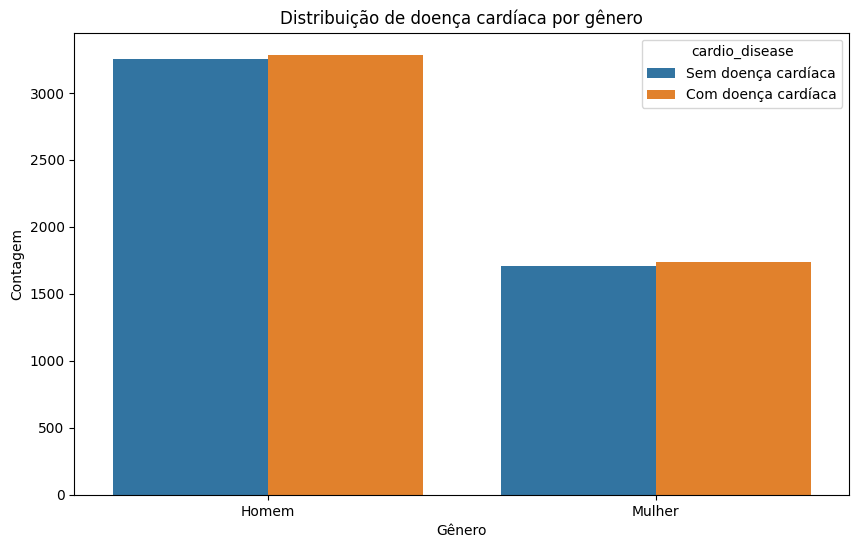

In [10]:
# Criando os gráficos

Gen_Cardio = (df.groupby(['gender', 'cardio_disease']).size().reset_index(name='count'))
Gen_Cardio['cardio_disease'] = Gen_Cardio['cardio_disease'].map({
    0: 'Sem doença cardíaca',
    1: 'Com doença cardíaca'
})

plt.figure(figsize=(10, 6))
sns.barplot(
    data=Gen_Cardio,
    x='gender',
    y='count',
    hue='cardio_disease'
)
plt.title("Distribuição de doença cardíaca por gênero")
plt.xticks([0, 1], ['Homem', 'Mulher'])
plt.ylabel("Contagem")
plt.xlabel("Gênero")
plt.show()

# Cholesterol x Cardio_diseas
(Colesterol x Doença Cardíaca)

Motivo: Colesterol aparenta ser um indicador forte para desenvolver alguma doença cardíaca, logo resolvi fazer um gráfico para verificar se isso é verdade, e principalmente, se nessa base de dados, ele é ou não um fator de forte relevância para desenvolver doenças cardíacas.

Insights: De fato, após a análise gráfico foi possível ver que o colesterol é sim um im indicador forte para desenvolver alguma doença cardíaca, principalmente quando comparado com pessoas do mesmo grupo, ou seja, pessoas com colesterol normal, a maioria não desenvolveu doenças cardíacas, mas pessoas com o colesterol muito acima do normal, a maior parte desenvolveu doenças cardíacas. Logo, para traçar um grupo de risco, o colesterol é sim um fator bem importante.

Text(0.5, 1.0, 'Colesterol x desenvolver doençar cardíacas')

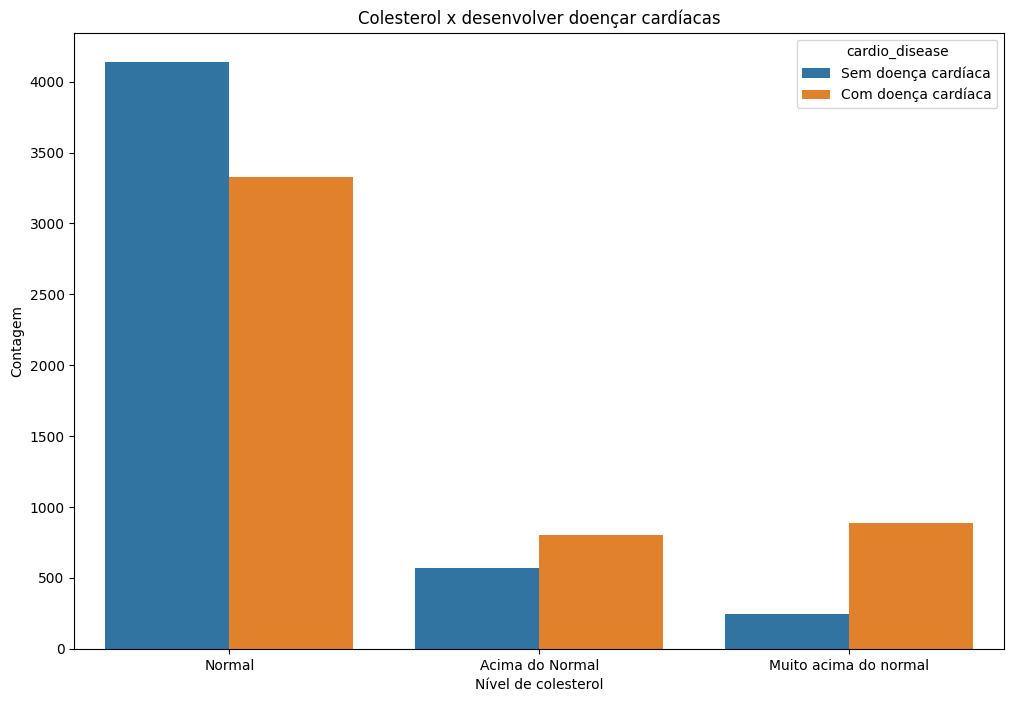

In [11]:
# Utilizando groupby para conseguir criar o gráfico

coles_cardio = (df.groupby(["cholesterol", "cardio_disease"]).size().reset_index(name='count'))
coles_cardio["cholesterol"] = coles_cardio["cholesterol"].map({
    1: "Normal",
    2: "Acima do Normal",
    3: "Muito acima do normal"
})
coles_cardio["cardio_disease"] = coles_cardio["cardio_disease"].map({
    0: "Sem doença cardíaca",
    1: "Com doença cardíaca"
})

# Criando gráfico para cholesterol x cardio_disease

plt.figure(figsize=(12,8))
sns.barplot(
    coles_cardio,
    x='cholesterol',
    y='count',
    hue='cardio_disease'
)
plt.xlabel("Nível de colesterol")
plt.ylabel("Contagem")
plt.title("Colesterol x desenvolver doençar cardíacas")

# Age x Cardio_diase
(Idade x  Doença Cardíaca)

Motivo: Escolhi esse gráfico pelo mesmo motivo do primeiro, idade pode ser um um fator importante, e tiver alguma relação, será mais fácil definir quais são os grupo com os maiores riscos de desenvolver alguma doença cardíaca.

Insight: A partir do grráfico foi possível ver que a idade tem sim uma relação, e principalmente, que pessoas mais velhas tme um propenção muito maior de desenvolver doençar cardíacas, podendo ser por vários motivos, mas deixando a conclusão que idade é sim um fator para definir um grupo de risco...

Text(0.5, 1.0, 'Distribuição de idade e pessoas que desenvolveram alguma doença cardíaca')

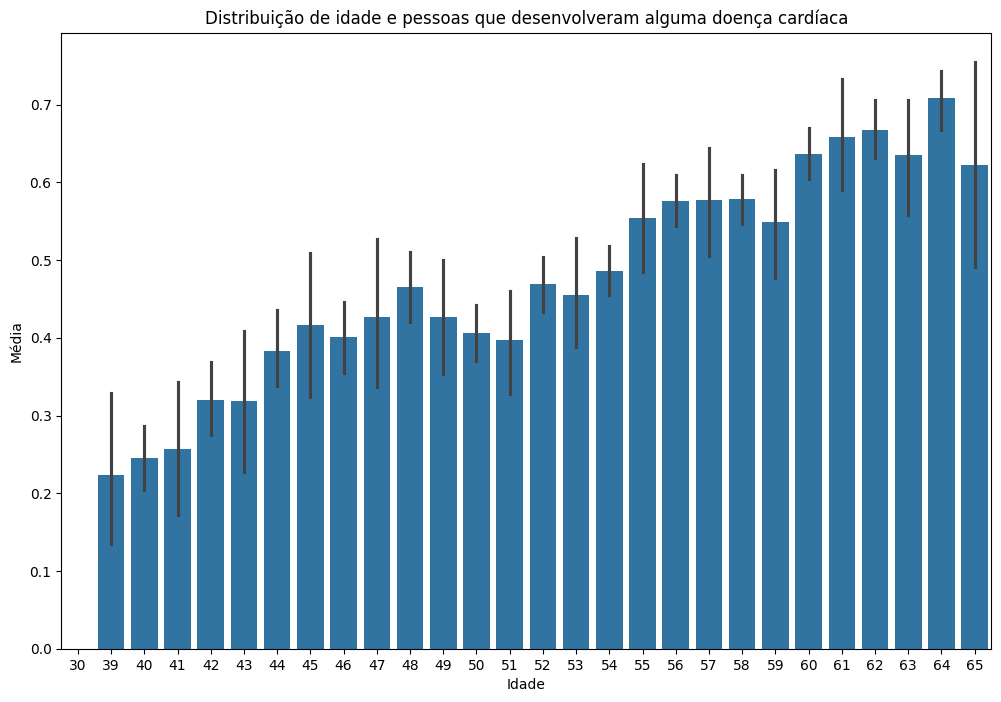

In [12]:
# Criando gráficos

plt.figure(figsize=(12,8))
sns.barplot(
    data=df,
    x="age",
    y="cardio_disease"
)
plt.ylabel("Média")
plt.xlabel("Idade")
plt.title("Distribuição de idade e pessoas que desenvolveram alguma doença cardíaca")

# 3) Nessa etapa você deve trazer a matriz de correlação e apontar insights acerca das variáveis com um relacionamento mais forte entre si.



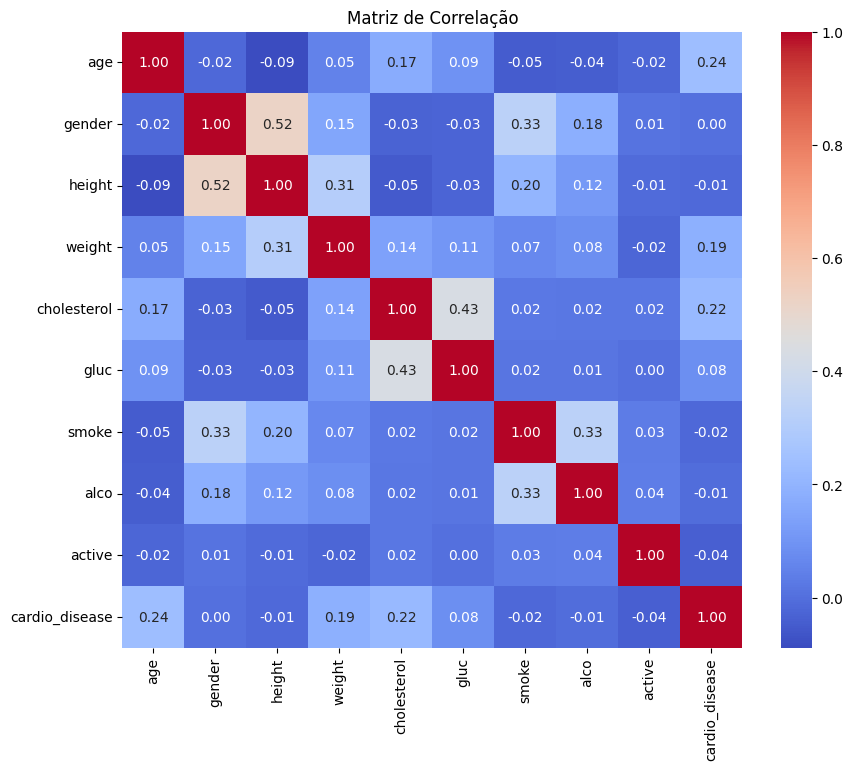

In [13]:
matriz_corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Matriz de Correlação')
plt.show()

Insights:

- As categorias com maior correlação com cardio_disease são idade e colesterol, mostrando que a escolha da criação do gráfico foi sim bem positiva, para maior entendimento da variável alvo, esse compreendimento facilita na hora de indentificar um grupo de risco, e também como sugestão, se torna extr=emamente indicável para mendicos, ao se depararem com pacientes mais novos em seus consultórios, fazerem um exame para descobrir como está o coleterol...

- Outro fator interessante é que glicose não está diretamente relacionado com doenças cardíacas, mas esta fortemente relacionando com colesterol, que por sua vez possue correlação com a variável alvo, podendo ser também, outro fator para descobrir grupos de riscos.

- Interessante apontar que peso também tem um correlação alto com a variável alvo, o que faz sentindo, visto que muitos dos casos, principalmente com pessoas que não praticam atividades físicas, o peso está relacionado com massa gorda (Gordura) e não massa magra, e um alto percentual de gordura no corpo aumenta as chaces de desenvolver doenças cardíacas.

# 4) Essa é a sua última etapa pré modelo. Você deve:

A) Separar a base em treino e teste.

B) Você considera que essa base precisa que os dados sejam padronizados? Se sim, porque? Se acredita que devem, então realize essa etapa.

C) Verifique se os dados estão balanceados, se não, faça o balanceamento.


D) Visualize as bases de treino, teste (X E Y) e verifique se está tudo adequado.

In [14]:
# Separando em features

X = df.drop("cardio_disease", axis=1)
y = df["cardio_disease"]

# Realizando o separação em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

# Vou verificar se foi tudo certinho com shape

print("Shape de X train:", X_train.shape)
print("\nShape de X test:", X_test.shape)
print("\nShape de y train:", y_train.shape)
print("\nShape de y test:", y_test.shape)

Shape de X train: (7981, 9)

Shape de X test: (1996, 9)

Shape de y train: (7981,)

Shape de y test: (1996,)


Observação:
Os dados foram separados com sucesso, diz a divisão 80 20, logo 80% dos dados estão em treino, achei que fez sentido realizar essa divisão pois não temos muitos dados, logo um treino maior é importante.

In [15]:
# Realizando padronização dos dados

sc = StandardScaler()

# Padronização do treino

X_train = sc.fit_transform(X_train)

# Padronização do teste

X_test = sc.fit_transform(X_test)

Resposta:
Eu acredito que realizar a padronização desses dados vai ser sim importante, principalmente poque estamos trabalhando com regressão logística, não temos valores extremamente altos, o máximo que vamos encontrar é o valor 195, mas mesmo assim acredito que a padronização vai facilitar o apredizado do modelo.

In [16]:
# Verificando o balanceamento dos dados de treino

train_balance = pd.Series(y_train).value_counts().reset_index()
train_balance.columns = ['cardio_disease', 'count']

# Mapeando os valores para rótulos mais descritivos
train_balance['cardio_disease'] = train_balance['cardio_disease'].map({
    0: 'Sem doença cardíaca',
    1: 'Com doença cardíaca'
})

# Criando o gráfico de barras com plotly express
fig = px.bar(
    train_balance,
    x='cardio_disease',
    y='count',
    title='Distribuição das Classes nos Dados de Treino',
    labels={
        'count': 'Quantidade de Pacientes',
        'cardio_disease': 'Condição'
    },
    color='cardio_disease'
)
fig.show()



Observação:
O gráfico mostra que os dados estão sim bem balanceados, possuindo uma pequena diferença, mas vou realizar o smote de qualquer forma para deixar totalmente balanceado e evitar qual tipo de viés por quantidade de dados

In [17]:
# Realizando balanceamento

smote = SMOTE(random_state=48)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Realizando verificação

print("Shape de X train balanceado: ", X_train_balanced.shape)
print("\nShape de y train balanceado: ", y_train_balanced.shape)
print("\nShape de X test:", X_test.shape)
print("\nShape de y test:", y_test.shape)

Shape de X train balanceado:  (8046, 9)

Shape de y train balanceado:  (8046,)

Shape de X test: (1996, 9)

Shape de y test: (1996,)


Observação:
Agora está tudo balanceado e padronizado. E os shapes estão corretos

# 5) Realize a etapa de treinamento do modelo:

A) Faça o treinamento do modelo.

B) Traga o intercept e os coeficientes.

c) Avalie as métricas do modelo treinado

D) Justifique se te parece que o modelo tem feito boas previsões ou não.

In [18]:
# Criando modelo

logistic_R = LogisticRegression(random_state=48)

# Treinando o modelo

logistic_R.fit(X_train_balanced, y_train_balanced)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,48
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [19]:
# Verificando o intecept o os coef

print("Intercept: ", logistic_R.intercept_)

print("\nCoef: ", logistic_R.coef_)

Intercept:  [0.01707257]

Coef:  [[ 0.43359272  0.02631691 -0.09974441  0.36943288  0.41328335 -0.06397231
  -0.05024601 -0.00332384 -0.07675435]]


In [20]:
# Avaliando o modelo com os dados de trinamento

previsoes_treino = logistic_R.predict(X_train_balanced)

relatorio_treino = classification_report(y_train_balanced, previsoes_treino)
print("Relatório treino: ")
print(relatorio_treino)

Relatório treino: 
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      4023
           1       0.65      0.60      0.63      4023

    accuracy                           0.64      8046
   macro avg       0.64      0.64      0.64      8046
weighted avg       0.64      0.64      0.64      8046



Resposta:

O modelo não apresentou métricas muitos boas mostrando, que talvez ele não tenha entendido muito bom o que certas variáveis indicavam... a acúracia dele ficou relativamente baixa, sendo no caso 0.64, apontando que ele não conseguiu interpretar muito bem ops dados, o recall foi 60 para quem realmente tinha alguma doença o que é bem preocupante pois do total de pessoas que tinham ele só acertou 60%. Estamos fazendo com traino e o resultado não foi nada bom pois o treino costuma ter resultados mais positivos, é claro que a avaliação real será em teste, mas esse ínicio foi bem ruim, principalmente pois o modelo está realizando predisões na área da saúde, ou seja, apenas exelência é esparado, visto que ele está trabalhando com vidas.

# 6) Teste seu modelo!

A) Aplique o modelo aos dados de teste.

B) Avalie as métricas do modelo treinado

C) Plote o gráfico da curva AUC-ROC e explique o que consegue analisar através do gráfico.

In [21]:
previsoes = logistic_R.predict(X_test)

relatorio = classification_report(y_test, previsoes)
print("Relatório de teste: ")
print(relatorio)

Relatório de teste: 
              precision    recall  f1-score   support

           0       0.64      0.67      0.65       997
           1       0.65      0.62      0.63       999

    accuracy                           0.64      1996
   macro avg       0.64      0.64      0.64      1996
weighted avg       0.64      0.64      0.64      1996



Resposta:

O modelo teve um resultado bem próximo ao modelo de treino, mostando, que houve sim um certo compreendimento das relações entre as variáveis, ainda assim, op modelo não se saiu muito bem, a acurácia se manteve igual, mas o recall de 1 melhorou, mas foi bem pouco apenas 0.04. Concluido o modelo demostrou ter potencial, os resultados de teste mostraram que não teve data leak e fez jus ao resultado de treino, todavia o modelo se encontra em um estágio que sua utilização não é recomenda, principalmente por ser na área da saúde, ele ainda erra bastante onde um erro pode ser vital.

OBS: Eu retirei a padronização, balanceamento remoção dos outliers, mas para minha surpresa a mudança foi quase nula, o modelo se saiu um pouquinho pior em algumas métricas (Diferença de 1%), mostrando que a razão para o baixo desempenho do modelo não está nas alterações.

AUC: 0.64


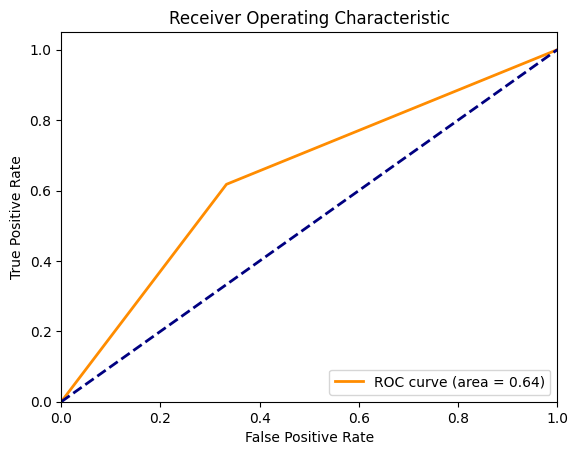

In [22]:
# Gráfico AUC-ROC

fpr, tpr, thresholds = roc_curve(y_test, previsoes)

# Calculando a AUC
roc_auc = roc_auc_score(y_test, previsoes)
print("AUC: {:.2f}".format(roc_auc))

# Gráfico

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Observação: O gráfico também mostra a ineficácia do modelo, visto que a curva esta bem longe de chegar em 1, mostrando que a área de acerto é bem pequena.

# 7) Explique:

A) Explique com suas palavras regressão logistica.

B) Explique porque a regressão logistica é um modelo de classificação.

C) Explique quais pontos em comum a regressão logistica tem da regressão linear.



A) Resposta: A regressão logística é um modelo de machine learning de aprendizado supervisionado e é classificação, ela é relativamente parecia com a regressão linear múltipla no sentido do caminho para traçar um reta, mas a principal diferença entre elas é que a regressão linear diz um valor continuo, ja a regressão logística diz a probabilidade de um evento acontecer, 0 ou 1, e ela faz isso pegando as outras váriaveis e calculando probabilidades apartir delas, no final se a variável alvo, por padrão, da um valor acima de 50% ela diz que tal coisa vai acontecer se for abaixo, ela diz que não vai.

B) Resposta: É um modelo de classificação pois ela não entrega nenhum valor, o que ela faz é dizer se algo vai ou não acontecer com base nos dados históricos e calculando as probabilidades por meio da função sigmoide (Tentando traçar uma reta, mas uma reta que "faz" curvas). Logo, ela só poderia ser classificação, pois ela "classifica" algo dentro de 2 grupos, vai aconter ou não vai.

C) As principais semalhanças estão dentro do caminho para entregar o resultado, os cálculos iniciais com os coef acontecem nas duas, principalmente se compararmos com a regressão linear múltiplas ao invés da simples, pois nesse caso o cálculo das múltiplas várias é igual nas duas. E é claro, as duas tentam traçar uma reta, mas são retas diferentes.